In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2 as cv
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

2023-04-18 20:17:38.537637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 20:17:38.753855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-18 20:17:38.753914: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-18 20:17:39.880868: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
dev_qnn = qml.device('default.qubit', wires=range(8))

In [3]:
data = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [4]:
(x_train, y_train), (x_test, y_test) = data

In [5]:
fives_train, f_train = x_train[y_train == 5], y_train[y_train == 5]
fives_test, f_test = x_test[y_test == 5], y_test[y_test == 5]

In [6]:
ones_train, o_train = x_train[y_train == 1], y_train[y_train == 1]
ones_test, o_test = x_test[y_test == 1], y_test[y_test == 1]

In [7]:
train, test = np.vstack((fives_train, ones_train)), np.vstack((fives_test, ones_test))
target_train, target_test = np.hstack((f_train, o_train)), np.hstack((f_test, o_test))

In [8]:
set_train, t_train = shuffle(train, target_train, random_state=0)
set_test, t_test = shuffle(test, target_test, random_state=0)

In [9]:
t_train = t_train.astype(np.int64)
t_test = t_test.astype(np.int64)

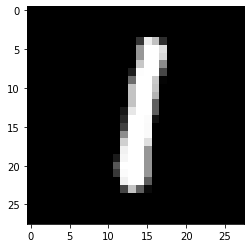

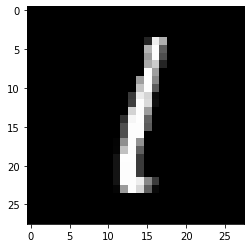

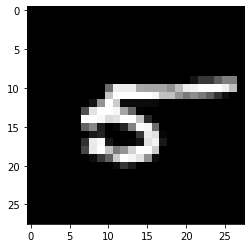

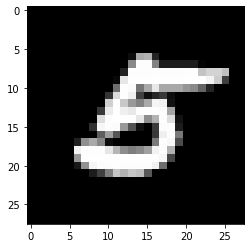

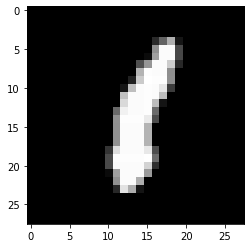

In [179]:
for i in range(5):
    plt.imshow(set_train[i], cmap='gray')
    plt.show()

In [10]:
t_train[t_train == 1] = -1
t_train[t_train == 5] = 1
t_test[t_test == 1] = -1
t_test[t_test == 5] = 1

In [11]:
train_norm = []
for img in set_train:
    img_resize = cv.resize(img, (16, 16), interpolation=cv.INTER_LINEAR)
    img_norm = cv.normalize(img_resize, None, alpha=0,beta=1, norm_type=cv.NORM_MINMAX)
    img_reshape = img_norm.reshape((256,))
    norm = np.linalg.norm(img_reshape)
    train_norm.append(img_reshape / norm)
train_norm = np.array(train_norm)

In [12]:
test_norm = []
for img in set_test:
    img_resize = cv.resize(img, (16, 16), interpolation=cv.INTER_LINEAR)
    img_norm = cv.normalize(img_resize, None, alpha=0,beta=1, norm_type=cv.NORM_MINMAX)
    img_reshape = img_norm.reshape((256,))
    norm = np.linalg.norm(img_reshape)
    test_norm.append(img_reshape / norm)
test_norm = np.array(test_norm)

In [13]:
def amplitude_embedding(features, quants):
    qml.AmplitudeEmbedding(features=features, wires=quants)

In [14]:
def q_conv_circuit_1(theta, quants):
    qml.RY(theta[0], wires=quants[0])
    qml.RY(theta[1], wires=quants[1])
    qml.CNOT(wires=quants)

In [15]:
def q_conv_circuit_2(theta, quants):
    qml.Hadamard(wires=quants[0])
    qml.Hadamard(wires=quants[0])
    qml.CZ(wires=quants)
    qml.CRX(theta[0], wires=quants[0])
    qml.CRX(theta[1], wires=quants[1])

In [16]:
def q_conv_circuit_3(theta, quants):
    qml.RY(theta[0], wires=quants[0])
    qml.RY(theta[1], wires=quants[1])
    qml.CNOT(wires=(quants[1], quants[0]))
    qml.RY(theta[2], wires=quants[0])
    qml.RY(theta[3], wires=quants[1])
    qml.CNOT(wires=quants)

In [17]:
def q_pool_circuit(theta, quants):
    qml.CRZ(theta[0], wires=quants)
    qml.PauliX(wires=quants[0])
    qml.CRX(theta[1], wires=quants)

In [18]:
@qml.qnode(dev_qnn)
def qcnn(img, theta):
    qubits = range(8)
    amplitude_embedding(img, qubits)
    theta_i = 0
    # 1 layer
    for q_i, q_j in zip(range(0, 8, 2), range(1, 8, 2)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    for q_i, q_j in zip(range(1, 8, 2), range(2, 9, 2)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j % 8))
        theta_i += 2
    for q_i, q_j in zip(range(0, 8, 2), range(1, 8, 2)):
        q_pool_circuit(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    # 2 layer
    for q_i, q_j in zip(range(1, 8, 4), range(3, 8, 4)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    for q_i, q_j in zip(range(3, 8, 4), range(5, 10, 4)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j % 8))
        theta_i += 2
    for q_i, q_j in zip(range(1, 8, 4), range(3, 8, 4)):
        q_pool_circuit(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    # 3 layer
    q_conv_circuit_1(theta[theta_i:theta_i + 2], (3, 7))
    theta_i += 2
    q_pool_circuit(theta[theta_i:theta_i + 2], (3, 7))

    return qml.expval(qml.PauliZ(wires=7))

In [19]:
def cost(theta):
    N = train.shape[0]
    expvals = np.array([qcnn(img, theta) for img in train_norm])
    return 1/N * np.sum(np.power(expvals - t_train, 2))

In [20]:
def accuracy_test(theta):
    N = train.shape[0]
    expvals = np.array([qcnn(img, theta) for img in test_norm])
    return 1/N * np.sum(np.power(expvals - t_test, 2))

In [21]:
theta = np.zeros((40, ))

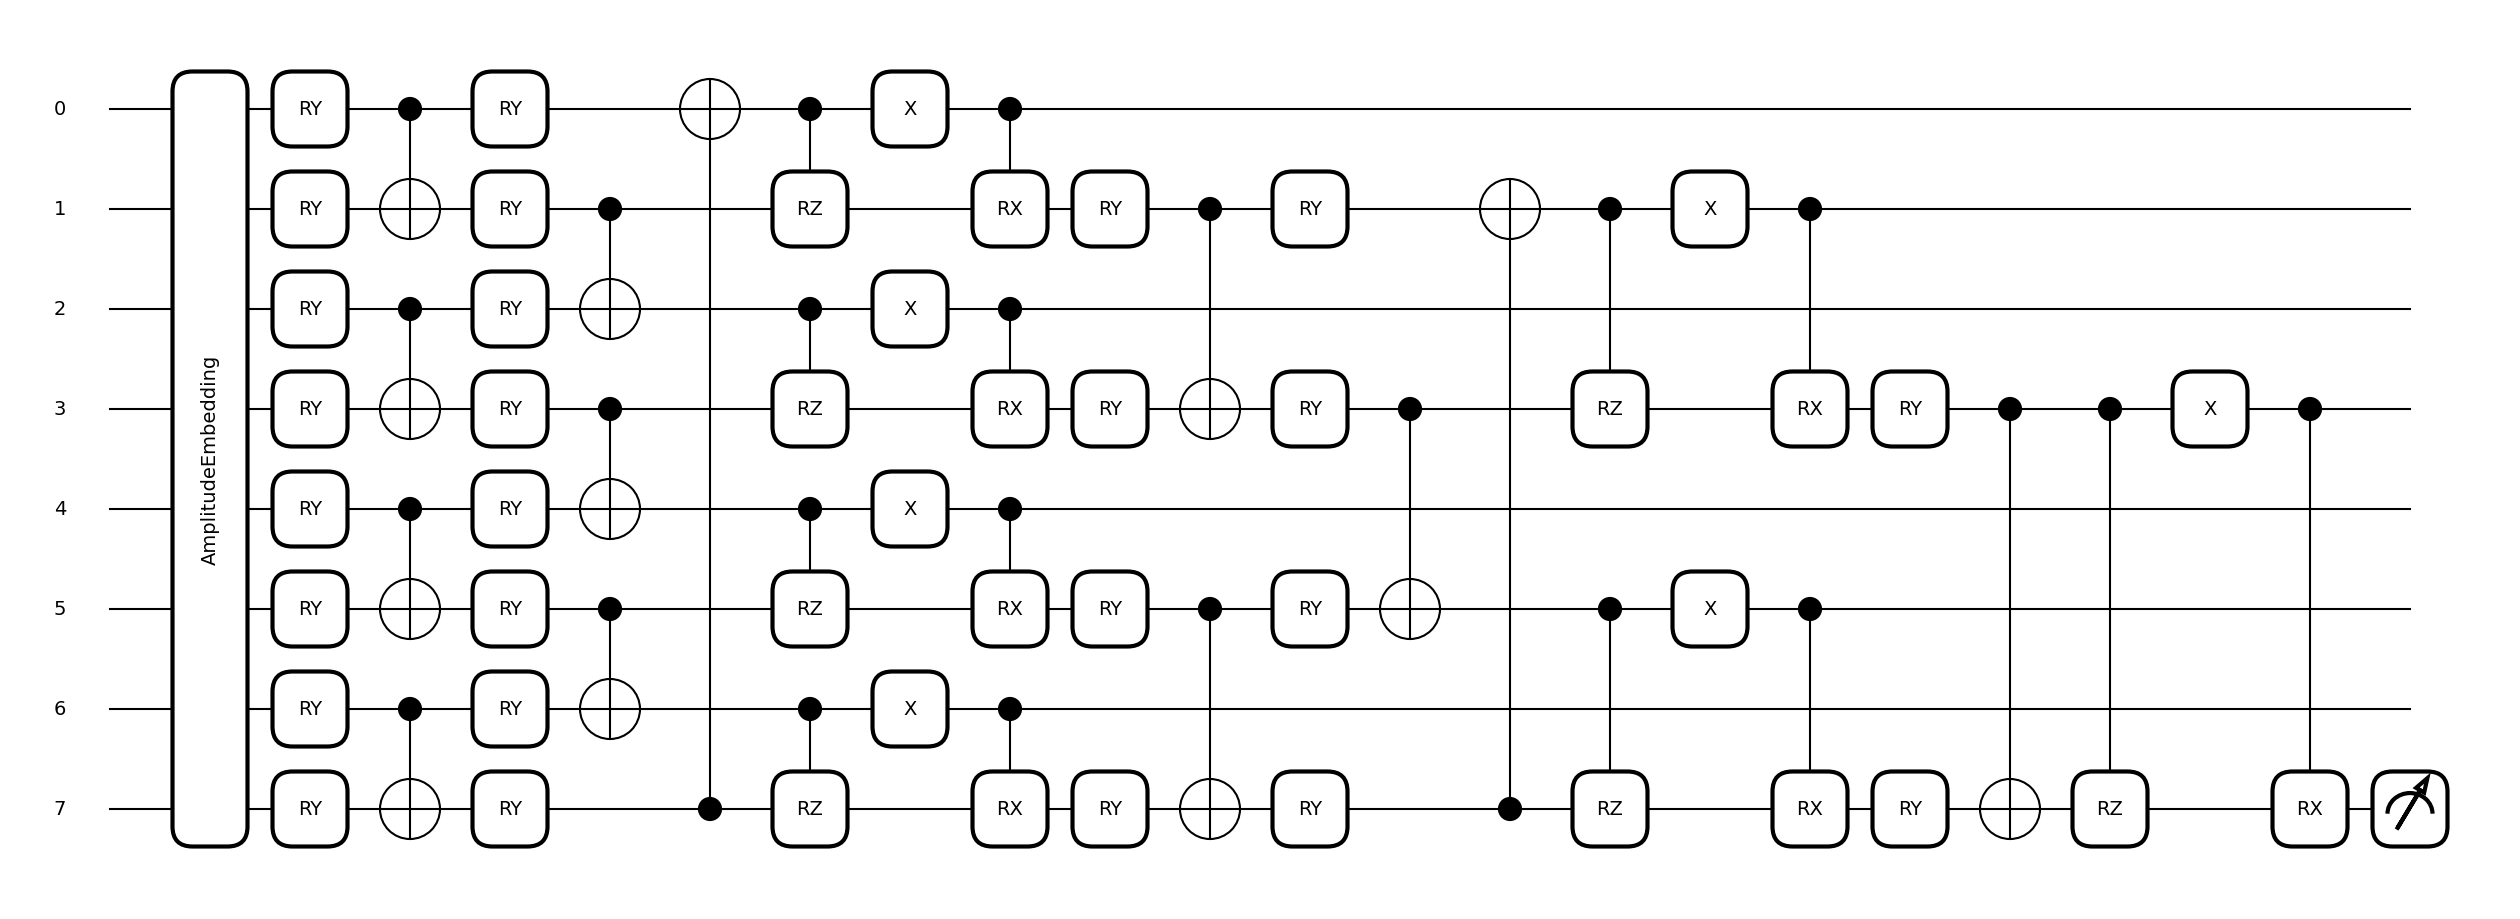

In [22]:
fig, ax = qml.draw_mpl(qcnn)(train_norm[0], theta)
plt.show()

In [214]:
opt = qml.GradientDescentOptimizer(0.01)

In [215]:
%%time
c_train = []
a_test = []
n_iter = 200
for i in range(n_iter):
    c_train.append(cost(theta))
    a_test.append(accuracy_test(theta))
    if i % 10 == 0:
        print(f'Iter: {i} Lost: {c_train[i]} Accuracy: {a_test[i]}')
    theta = opt.step(cost, theta)

Iter: 0 Lost: 1.0080603182310846 Accuracy: 0.1663352061256396
Iter: 10 Lost: 0.9941533566481806 Accuracy: 0.16392198051045315
Iter: 20 Lost: 0.9808125323348843 Accuracy: 0.16161282061901353
Iter: 30 Lost: 0.9680432182204295 Accuracy: 0.1594081680739033
Iter: 40 Lost: 0.9558449884829497 Accuracy: 0.15730743735097455
Iter: 50 Lost: 0.9442122852615026 Accuracy: 0.15530914235357038
Iter: 60 Lost: 0.9331351425758746 Accuracy: 0.15341103246195428
Iter: 70 Lost: 0.9225999220851976 Accuracy: 0.15161022969291021
Iter: 80 Lost: 0.9125900244494134 Accuracy: 0.1499033603302087
Iter: 90 Lost: 0.9030865504318165 Accuracy: 0.1482866763355414
Iter: 100 Lost: 0.8940688958569175 Accuracy: 0.14675616371573197
Iter: 110 Lost: 0.8855152730363345 Accuracy: 0.14530763660601878
Iter: 120 Lost: 0.8774031577770453 Accuracy: 0.1439368170364155
Iter: 130 Lost: 0.8697096655263015 Accuracy: 0.14263940116838725
Iter: 140 Lost: 0.8624118628246474 Accuracy: 0.1414111132680119
Iter: 150 Lost: 0.8554870214262295 Accurac

In [243]:
print(f'Theta: {theta}')

Theta: [-3.21133822e-02 -2.58870226e-02 -3.80345085e-03 -2.38244419e-02
 -4.69211995e-03  3.59494978e-03 -2.76158544e-03 -2.74983544e-02
 -2.60546155e-02  6.73610669e-04  5.58332841e-01 -3.82670613e-03
 -6.24736976e-03  4.09106714e-04 -1.48461493e-01 -6.24823356e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.94719663e-02  9.44623619e-03 -1.60540193e-02 -5.94569629e-02
 -3.81561620e-02 -2.54985121e-04  5.86338804e-02 -5.12539705e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.19173047e-02  2.30940575e-02  0.00000000e+00  0.00000000e+00]


In [226]:
%%time
result_predict = []
for i in test_norm:
    result_predict.append(1 if qcnn(i, theta) > 0 else -1)

CPU times: user 1min 7s, sys: 16.2 ms, total: 1min 7s
Wall time: 1min 7s


In [229]:
y_predict = result_predict.copy()
y_target = t_test.copy()

In [241]:
def print_result(y_target, y_predict):
    print(f'Accuracy: {accuracy_score(y_target, y_predict)}')
    print(f'Recall: {recall_score(y_target, y_predict)}')
    print(f'Precision: {precision_score(y_target, y_predict)}')
    print(f'F1-score: {f1_score(y_target, y_predict)}')

In [242]:
print_result(y_target, y_predict)

Accuracy: 0.7217562900838678
Recall: 0.5616591928251121
Precision: 0.7433234421364985
F1-score: 0.639846743295019


In [244]:
@qml.qnode(dev_qnn)
def qcnn_with_prob(img, theta):
    qubits = range(8)
    amplitude_embedding(img, qubits)
    theta_i = 0
    # 1 layer
    for q_i, q_j in zip(range(0, 8, 2), range(1, 8, 2)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    for q_i, q_j in zip(range(1, 8, 2), range(2, 9, 2)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j % 8))
        theta_i += 2
    for q_i, q_j in zip(range(0, 8, 2), range(1, 8, 2)):
        q_pool_circuit(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    # 2 layer
    for q_i, q_j in zip(range(1, 8, 4), range(3, 8, 4)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    for q_i, q_j in zip(range(3, 8, 4), range(5, 10, 4)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j % 8))
        theta_i += 2
    for q_i, q_j in zip(range(1, 8, 4), range(3, 8, 4)):
        q_pool_circuit(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    # 3 layer
    q_conv_circuit_1(theta[theta_i:theta_i + 2], (3, 7))
    theta_i += 2
    q_pool_circuit(theta[theta_i:theta_i + 2], (3, 7))

    return qml.probs(wires=7)

In [247]:
t_train[]

tensor(1, requires_grad=True)

In [246]:
qcnn_with_prob(train_norm[0], theta)

tensor([0.34576468, 0.65423532], requires_grad=True)

In [248]:
qcnn_with_prob(train_norm[3], theta)

tensor([0.55303411, 0.44696589], requires_grad=True)

In [249]:
%%time
measure_probs = []
for i in test_norm:
    measure_probs.append(qcnn_with_prob(i, theta))

CPU times: user 1min 31s, sys: 47.6 ms, total: 1min 31s
Wall time: 1min 32s


In [257]:
y_predict = np.argmax(measure_probs, axis=1)
y_target = t_test.copy()
y_target[y_target == 1] = 0
y_target[y_target == -1] = 1

In [259]:
print_result(y_target, y_predict)

Accuracy: 0.7217562900838678
Recall: 0.8475770925110132
Precision: 0.7110125646711013
F1-score: 0.7733118971061094


In [260]:
np.save('./models/simple_qcnn_with_qconv1_expval.npy', theta)

In [264]:
probs = np.sqrt(measure_probs[0])

In [266]:
np.arccos(probs[0])

tensor(0.69668497, requires_grad=True)

In [267]:
np.arcsin(probs[1])

tensor(0.69668497, requires_grad=True)

In [269]:
x_train.shape[0] + x_test.shape[0]

70000